In [1]:
from msclap import CLAP
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import pandas as pd
import os

In [2]:
specialities = pd.read_csv('specialities.csv')
display(specialities)

speciality_subtypes_v1 = {
    'bell':['bell'],
	'bird':['wild_animals'],
	'car':['engine', 'vehicle'],
	'car_cabin': ['engine', 'vehicle'],
	'dog':['domestic animals/pets'],
	'door':['generic impact sounds', 'domestic sounds/home sounds'],
	'eating':['surface contact', 'generic impact sounds', 'food packaging', 'eating/digestive'],
	'fan':['fan/air conditioning'],
	'kids_screaming':['other', 'instrumental music'],
	'kitchen_noises':['domestic sounds/home sounds', 'generic impact sounds'],
	'low_rev_engines':['engine'],
	'water':['liquid/water'],
	'wind':['weather']
}

speciality_subtypes_v2 = {
    'bell':['bell'],
	'bird':['wild_animals'],
	'car':['engine', 'vehicle'],
	'car_cabin': ['vehicle'],
	'dog':['domestic animals/pets'],
	'door':['generic impact sounds', 'domestic sounds/home sounds'],
	'eating':['eating/digestive'],
	'fan':['fan/air conditioning'],
	'kids_screaming':['other', 'instrumental music'],
	'kitchen_noises':['domestic sounds/home sounds'],
	'low_rev_engines':['engine'],
	'water':['liquid/water'],
	'wind':['weather']
}

,speciality,meta_csv,audios
0,bell,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
1,bird,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
2,car,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
3,car,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
4,car_cabin,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
5,dog,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
6,door,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
7,eating,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
8,fan,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...
9,kids_screaming,/bucket/data_collection/datasets/purchased_dat...,/bucket/data_collection/datasets/purchased_dat...


In [3]:
metadf_dict={}
speciality_dict={}
for row in specialities.itertuples(index=False):
    #print(f"working on {row.speciality}")
    csv = pd.read_csv(row.meta_csv)
    #print(csv['sub_type'].value_counts())
    csv = csv[csv['sub_type'].isin(speciality_subtypes_v2[row.speciality])]
    #print(csv['sub_type'].value_counts())
    
    metadf_dict[row.speciality] = csv
    
    audio_paths = metadf_dict[row.speciality]['filepath']
    speciality_dict[row.speciality] = list(audio_paths)

In [4]:
prompt_mapping_v1 = {'water':'water',
                  'eating':'eating',
                  'car_cabin':'inside of car',
                  'bell':'bell',
                  'door':'door',
                  'wind':'wind',
                  'bird':'bird',
                  'kitchen_noises':'kitchen appliances cooking',
                  'kids_screaming':'kids screaming',
                  'car':'car',
                  'dog':'dog',
                  'low_rev_engines':'engine',
                  'fan':'fan'}

prompt_mapping_v2 = {'water':'water',
                  'eating':'eat',
                  'car_cabin':'inside car',
                  'bell':'bell',
                  'door':'door',
                  'wind':'wind',
                  'bird':'bird',
                  'kitchen_noises':'kitchen',
                  'kids_screaming':'kids',
                  'car':'car',
                  'dog':'dog',
                  'low_rev_engines':'engine',
                  'fan':'fan'}

prompt_mapping_v3 = {'water':'water',
                  'eating':'eat and drink',
                  'car_cabin':'inside car',
                  'bell':'chime',
                  'door':'door',
                  'wind':'wind',
                  'bird':'bird',
                  'kitchen_noises':'kitchen',
                  'kids_screaming':'kids',
                  'car':'car',
                  'dog':'dog',
                  'low_rev_engines':'idling truck',
                  'fan':'fan'}

prompt_mapping_v4 = {'water':'water',
                  'eating':'eating and drinking',
                  'car_cabin':'inside car',
                  'bell':'bell and chime',
                  'door':'door',
                  'wind':'wind',
                  'bird':'bird',
                  'kitchen_noises':'cooking in kitchen',
                  'kids_screaming':'kids screaming',
                  'car':'car',
                  'dog':'dog',
                  'low_rev_engines':'idling truck',
                  'fan':'fan'}

In [8]:
records = []
for specialty, file_paths in speciality_dict.items():
    specialty_prompt = prompt_mapping_v4[specialty]
    #specialty_prompt = specialty
    for file_path in file_paths:
        records.append({'specialty': specialty_prompt, 'file_path': file_path})

# Create a DataFrame
df = pd.DataFrame(records)
print(df['specialty'].value_counts())

specialty
water                  1945
bell and chime         1582
door                   1582
inside car              960
wind                    865
car                     650
cooking in kitchen      555
eating and drinking     520
idling truck            493
kids yelling            466
dog                     462
fan                     164
Name: count, dtype: int64


In [9]:
df['specialty'].value_counts().sum()

10244

In [10]:
classes = df['specialty'].unique()
print(classes)

class_id_map = {name: i for i, name in enumerate(classes, 0)}
id_class_map =  {v: k for k, v in class_id_map.items()}
print(class_id_map)

prompt = 'this is the sound of '
y = [prompt + x for x in classes]

['bell and chime' 'car' 'inside car' 'dog' 'door' 'eating and drinking'
 'fan' 'kids yelling' 'cooking in kitchen' 'idling truck' 'water' 'wind']
{'bell and chime': 0, 'car': 1, 'inside car': 2, 'dog': 3, 'door': 4, 'eating and drinking': 5, 'fan': 6, 'kids yelling': 7, 'cooking in kitchen': 8, 'idling truck': 9, 'water': 10, 'wind': 11}


In [11]:
# Load and initialize CLAP
clap_model = CLAP(version = '2023', use_cuda=True)

# Computing text embeddings
text_embeddings = clap_model.get_text_embeddings(y)

In [12]:
# Computing audio embeddings
y_preds, y_labels = [], []
print(os.getcwd())

for i in tqdm(range(len(df ))):
    label, path = df.iloc[i]
    idx = class_id_map[label]
    #print(idx)
    one_hot_target = torch.nn.functional.one_hot(torch.tensor([idx]), num_classes=len(classes)+1)
    if i == 0: print(f'\nlabel: {label}, idx: {idx}, one hot target: {one_hot_target}')
    
    audio_embeddings = clap_model.get_audio_embeddings([path], resample=True)
    if i == 0: print(f'\naudio embedding: {audio_embeddings} {np.shape(audio_embeddings)}')
    
    similarity = clap_model.compute_similarity(audio_embeddings, text_embeddings)
    if i == 0: print(f'\nsimilarity: {similarity} {np.shape(similarity)}')

    y_pred = F.softmax(similarity.detach().cpu(), dim=1).numpy()
    if i == 0: print(f'\ny pred: {y_pred}')
    
    y_preds.append(y_pred)
    y_labels.append(one_hot_target.detach().cpu().numpy())


/mounts/ud-data/jtaylor/a5f2c23d-7fb6-41a6-ac0c-3a2ffc02b992/data/acoustic_scene_classification/CLAP-main/examples


  0%|          | 1/10244 [00:00<17:09,  9.95it/s]


label: bell and chime, idx: 0, one hot target: tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

audio embedding: tensor([[ 0.4054, -0.5965, -0.4147,  ..., -0.3984,  0.2080, -1.4573]]) torch.Size([1, 1024])

similarity: tensor([[15.0247,  0.4373,  0.8133,  1.5173,  0.6013,  5.1747, -0.4535, -0.5265,
          2.2542, -2.1693,  3.9139, -0.9162]], grad_fn=<PermuteBackward0>) torch.Size([1, 12])

y pred: [[9.9992573e-01 4.6210010e-07 6.7299067e-07 1.3606524e-06 5.4442631e-07
  5.2741445e-05 1.8960446e-07 1.7625312e-07 2.8430434e-06 3.4094302e-08
  1.4948411e-05 1.1937124e-07]]


100%|██████████| 10244/10244 [12:11<00:00, 14.01it/s]


In [15]:
y_lab, y_pred = np.concatenate(y_labels, axis=0), np.concatenate(y_preds, axis=0)
y_label_val = np.argmax(y_lab, axis=1)
y_pred_val = np.argmax(y_pred, axis=1)
acc = accuracy_score(np.argmax(y_lab, axis=1), np.argmax(y_pred, axis=1))
print('Speciality Accuracy {}'.format(acc))

Speciality Accuracy 0.8020304568527918


In [27]:
y_pred_val
for k, pred in enumerate(y_preds):
    print(y_preds[k][0][y_pred_val[k]])

0.99997854
0.98984796
0.99999213
0.99998486
0.9999734
0.9999889
0.47278684
0.806931
0.8321074
0.58885163
0.9915742
0.994087
0.9980355
0.9905545
0.9983614
0.9970214
0.99633056
0.98496777
0.9220342
0.97909385
0.9848889
0.99684393
0.98665524
0.9991732
0.9990441
0.9946584
0.9997224
0.5607296
0.35621867
0.77599466
0.8409823
0.9990914
0.9999459
0.9999273
0.99994576
0.9999603
0.99991703
0.9998939
0.8712571
0.98321664
0.9999676
0.99997485
0.99994624
0.99145013
0.9999485
0.9903655
0.99993193
0.99031407
0.99996257
0.9617473
0.99760556
0.99859196
0.99783
0.9984187
0.9990639
0.9567472
0.9976801
0.9999635
0.99999523
0.9952153
0.99854964
0.99571687
0.9782482
0.99343866
0.9864992
0.98765135
0.99441236
0.9347508
0.97908723
0.960649
0.9985519
0.9998087
0.9986021
0.99981445
0.97236335
0.8189146
0.74646235
0.756047
0.5353724
0.9076042
0.7636923
0.63664
0.7181942
0.8821721
0.9953491
0.69741285
0.7818901
0.8114705
0.8051116
0.85302347
0.46343258
0.89661527
0.9868492
0.80979604
0.9549216
0.78067744
0.798083

In [31]:
# Average for correct and incorrect
result = [a == b for a, b in zip(y_label_val, y_pred_val)]
df['correct'] = result
confidence = [y_preds[k][0][y_pred_val[k]] for k, pred in enumerate(y_preds)] 
df['confidence'] = confidence
display(df)

wrong_df = df[df['correct']==False]
correct_df = df[df['correct']==True]

print(np.mean(wrong_df['confidence']))
print(np.mean(correct_df['confidence']))

,specialty,file_path,correct,confidence
0,bell,/bucket/data_collection/datasets/purchased_dat...,True,0.999979
1,bell,/bucket/data_collection/datasets/purchased_dat...,True,0.989848
2,bell,/bucket/data_collection/datasets/purchased_dat...,True,0.999992
3,bell,/bucket/data_collection/datasets/purchased_dat...,True,0.999985
4,bell,/bucket/data_collection/datasets/purchased_dat...,True,0.999973
...,...,...,...,...
10239,wind,/bucket/data_collection/datasets/purchased_dat...,True,0.844358
10240,wind,/bucket/data_collection/datasets/purchased_dat...,True,0.997748
10241,wind,/bucket/data_collection/datasets/purchased_dat...,True,0.998579
10242,wind,/bucket/data_collection/datasets/purchased_dat...,True,0.998657


0.7056715
0.9249285


In [51]:

result = [a == b for a, b in zip(y_label_val, y_pred_val)]
df['correct'] = result
wrong_df = df[df['correct']==False].sample(50, random_state=1337)

In [56]:
display(wrong_df)
wrong_df.to_csv('tmp.csv')

,specialty,file_path,predicted,correct
3133,inside car,/bucket/data_collection/datasets/purchased_dat...,fan,False
2960,inside car,/bucket/data_collection/datasets/purchased_dat...,engine,False
938,bell,/bucket/data_collection/datasets/purchased_dat...,water,False
2055,car,/bucket/data_collection/datasets/purchased_dat...,inside car,False
6698,kitchen,/bucket/data_collection/datasets/purchased_dat...,engine,False
1655,car,/bucket/data_collection/datasets/purchased_dat...,inside car,False
6543,kitchen,/bucket/data_collection/datasets/purchased_dat...,eat,False
6969,engine,/bucket/data_collection/datasets/purchased_dat...,wind,False
2153,car,/bucket/data_collection/datasets/purchased_dat...,inside car,False
579,bell,/bucket/data_collection/datasets/purchased_dat...,water,False


In [55]:
print(list(wrong_df['file_path']))


['/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_car_cabin_noises_2023/audios/017/zapsplat_p1_car_cabin_noises_2023_003098.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_car_cabin_noises_2023/audios/006/zapsplat_p1_car_cabin_noises_2023_001195.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_bell_2023/audios/007/zapsplat_p1_bell_2023_01280.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_car_2023/audios/000/zapsplat_p1_car_2023_000246.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_kitchen_2023/audios/003/zapsplat_p1_kitchen_2023_00637.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_car_2023/audios/009/zapsplat_p1_car_2023_002794.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_kitchen_2023/audios/001/zapsplat_p1_kitchen_2023_00317.wav', '/bucket/data_collection/datasets/purchased_data/source/zapsplat_p1_low_rev_en

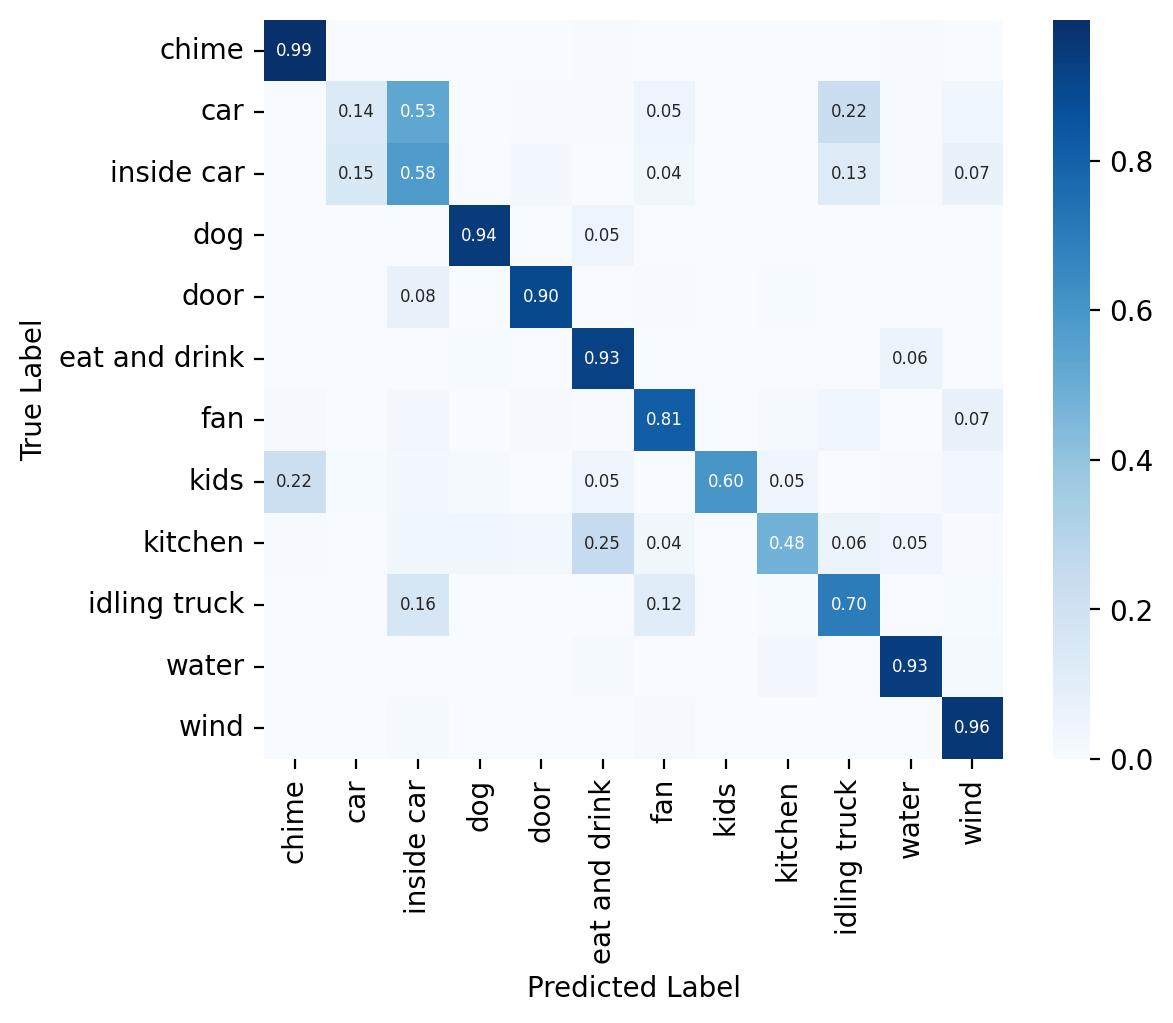

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# get confusion matrix
conf_matrix = confusion_matrix(y_label_val,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
mean_recall = np.mean(recall_by_class)

# Calculate row sums to use for percentages
row_sums = conf_matrix.sum(axis=1)

# Calculate percentages
percentages = (conf_matrix.T / row_sums).T  # Transpose for division, then transpose back

# Format percentages as strings with '%' symbol
annot_data = [['{:.2f}'.format(val) for val in row] for row in percentages]
annot_data = [['' if float(val <= 0.04) else '{:.2f}'.format(val) for val in row] for row in percentages]

plt.figure(dpi=200)

annot_kws = {'size': 6}
ax = sns.heatmap(percentages, xticklabels=classes, yticklabels=classes, annot=annot_data, fmt='', square=True, cmap='Blues', annot_kws=annot_kws)
ax.set_xlabel('Predicted Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
ax.set_ylabel('True Label')

#plt.subplots_adjust(left=0.2, bottom=0.35)
plt.show()